In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders
from ssim import ssim
import imageio


# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# Hyperparameters
lr = 0.0002
num_epochs = 20000
device = torch.device("cuda")

# Dataloaders
train_dataloader, test_dataloader = get_dataloaders()

# Initialize models
generator = ResNeXt().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss functions
criterion_content = torch.nn.MSELoss()  # For content loss
criterion_adversarial = torch.nn.BCELoss()

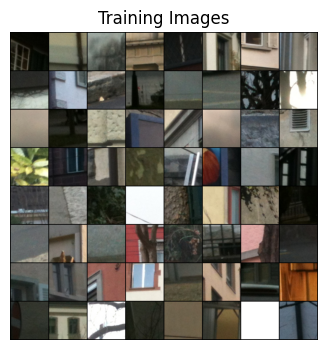

In [2]:
phone, dslr = next(iter(train_dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
# display the images with shape of torch.Size([3, 100, 100, 32])
plt.imshow(np.transpose(vutils.make_grid(phone), (1,2,0)))

In [3]:
def color_loss(generated, target):
    gen_mean, gen_std = torch.mean(generated, dim=[2, 3]), torch.std(generated, dim=[2, 3])
    target_mean, target_std = torch.mean(target, dim=[2, 3]), torch.std(target, dim=[2, 3])
    loss = torch.mean(torch.abs(gen_mean - target_mean) + torch.abs(gen_std - target_std))
    return loss

def total_variation_loss(image):
    tv_loss = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
              torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return tv_loss

ssim_loss = 0
n_epochs = 50  # Number of epochs
for epoch in range(n_epochs):
    for i, (phone_images, dslr_images) in enumerate(train_dataloader):

        phone_images, dslr_images = phone_images.to(device), dslr_images.to(device)
        current_batch_size = phone_images.size(0)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        enhanced_images = generator(phone_images)
        loss_content = criterion_content(enhanced_images, dslr_images)

        loss_color = color_loss(enhanced_images, dslr_images)
        loss_tv = total_variation_loss(enhanced_images)


        total_gen_loss = 10 * loss_content + 0.5 * loss_color + 20 * loss_tv
        total_gen_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        
        # Adjust the label size to match the current batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        
        # Discriminator loss for real images
        outputs_real = discriminator(dslr_images)
        loss_disc_real = criterion_adversarial(outputs_real, real_labels)

                # Discriminator loss for fake (generated) images
        outputs_fake = discriminator(enhanced_images.detach())
        loss_disc_fake = criterion_adversarial(outputs_fake, fake_labels)

        # Total discriminator loss
        total_disc_loss = loss_disc_real + loss_disc_fake
        total_disc_loss.backward()
        optimizer_D.step()


        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch}/{50}], Step [{i+1}/{len(train_dataloader)}], "
                f"Gen Loss: {total_gen_loss.item()}, Disc Loss: {total_disc_loss.item()}")

            # Save model checkpoints
            torch.save(generator.state_dict(), f'checkpoints/generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'checkpoints/discriminator_epoch_{epoch}.pth')

            # Example of saving a sample enhanced image
            sample_enhanced = enhanced_images[0]
            sample_original = phone_images[0]
            comparison = torch.cat((sample_original, sample_enhanced), dim=2)
            save_image(comparison, os.path.join('results', f'sample_epoch_{epoch}.jpg'))


Epoch [0/50], Step [100/2508], Gen Loss: 1.0842636823654175, Disc Loss: 0.0015947483479976654
Epoch [0/50], Step [200/2508], Gen Loss: 0.6385571956634521, Disc Loss: 0.0034339209087193012
Epoch [0/50], Step [300/2508], Gen Loss: 0.5922225713729858, Disc Loss: 0.0010010309051722288
Epoch [0/50], Step [400/2508], Gen Loss: 0.5468602180480957, Disc Loss: 0.00018670878489501774
Epoch [0/50], Step [500/2508], Gen Loss: 0.49776509404182434, Disc Loss: 0.0001565965940244496
Epoch [0/50], Step [600/2508], Gen Loss: 0.6047688722610474, Disc Loss: 9.968224912881851e-05
Epoch [0/50], Step [700/2508], Gen Loss: 0.5023727416992188, Disc Loss: 5.998148844810203e-05
Epoch [0/50], Step [800/2508], Gen Loss: 0.43738552927970886, Disc Loss: 0.00010241286508971825
Epoch [0/50], Step [900/2508], Gen Loss: 0.44915053248405457, Disc Loss: 4.464946687221527e-05
Epoch [0/50], Step [1000/2508], Gen Loss: 0.518631637096405, Disc Loss: 4.39418618043419e-05
Epoch [0/50], Step [1100/2508], Gen Loss: 0.513260781764

In [ ]:
# Save the model
torch.save({
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
    'loss': g_loss,
}, f"generator_epoch_{epoch}.pth")


In [ ]:
checkpoint = torch.load("generator_epoch_49.pth")
generator.load_state_dict(checkpoint['model_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [ ]:
from torchvision.utils import save_image
generator.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs_iphone, imgs_dslr = data
        imgs_iphone, imgs_dslr = imgs_iphone.to(device), imgs_dslr.to(device)
        gen_imgs = generator(imgs_iphone)
        
        save_image(gen_imgs, f"images/image_{i}.jpg")
